# Adversarial Variational Optimization: Poisson benchmark

In [1]:
import torch
import cag
import matplotlib.pyplot as plt

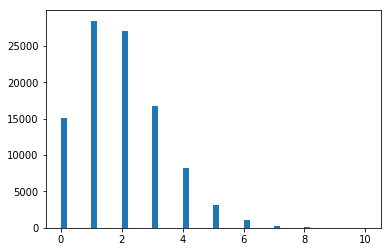

In [2]:
from cag.benchmark.poisson import allocate_observations

theta, x_o = allocate_observations(1.9)

plt.hist(x_o.numpy(), bins=50)
plt.show()

In [18]:
num_hidden = 50
discriminator = torch.nn.Sequential(
    torch.nn.Linear(1, num_hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(num_hidden, num_hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(num_hidden, num_hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(num_hidden, num_hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(num_hidden, 1),
    torch.nn.Sigmoid()
)

In [19]:
from cag.benchmark.poisson import PoissonSimulator as Simulator

simulator = Simulator()

In [20]:
from cag.proposal import NormalProposal

proposal = NormalProposal()

In [21]:
from cag.baseline import MeanBaseline

baseline = MeanBaseline(discriminator)

In [22]:
from cag.method import AdversarialVariationalOptimization

avo = AdversarialVariationalOptimization(simulator, discriminator, proposal, baseline=baseline)

In [23]:
proposal = avo.infer(x_o, num_iterations=5000)

In [24]:
proposal._mu

tensor(1.9193, requires_grad=True)

In [26]:
proposal._sigma

tensor(0.2127, requires_grad=True)

In [25]:
theta

tensor([1.9000])

In [29]:
print(proposal.log_prob(theta).item())

0.624780535697937
